In [ ]:
def create_trial_dataframe(data, valid_trial_mask, max_trials=240):
    """
    Create trial-level DataFrame with behavioral summary data.
    
    Parameters:
    - data: Loaded .mat file data dictionary
    - valid_trial_mask: Boolean array indicating valid trials
    - max_trials: Maximum number of trials to process
    
    Returns:
    - pd.DataFrame with trial-level data
    """
    # Extract basic trial data
    n_total = min(max_trials, len(data['cpoke_in'].flatten()))
    trial_ids = np.arange(np.sum(valid_trial_mask))
    
    # Timing data (already filtered to valid trials)
    cpoke_in = data['cpoke_in'].flatten()[:n_total][valid_trial_mask]
    cpoke_out = data['cpoke_out'].flatten()[:n_total][valid_trial_mask]
    clicks_on = np.array([clicks[0] for clicks in data['clicks_on'][:n_total]])[valid_trial_mask]
    first_clicks = np.array(data['first_clicks']).flatten()[:n_total][valid_trial_mask]
    last_clicks = np.array(data['last_clicks']).flatten()[:n_total][valid_trial_mask]
    
    # Choice and outcome data
    choices = data['pokedR'].flatten()[:n_total][valid_trial_mask].astype(int)
    rewarded = data['is_hit'].flatten()[:n_total][valid_trial_mask].astype(bool)
    violated = data['violated'].flatten()[:n_total][valid_trial_mask].astype(bool)
    
    # Calculate click counts per trial
    left_bups = data['left_bups'][:n_total][valid_trial_mask]
    right_bups = data['right_bups'][:n_total][valid_trial_mask]
    
    n_left_clicks = [len(clicks[0]) if clicks[0].size > 0 else 0 for clicks in left_bups]
    n_right_clicks = [len(clicks[0]) if clicks[0].size > 0 else 0 for clicks in right_bups]
    total_clicks = np.array(n_left_clicks) + np.array(n_right_clicks)
    
    # Derived features
    trial_duration = cpoke_out - cpoke_in
    click_duration = last_clicks - first_clicks
    time_to_first_click = first_clicks - clicks_on
    decision_time = cpoke_out - last_clicks
    
    # Click rate during stimulus period
    click_rate = total_clicks / click_duration
    click_rate[click_duration == 0] = 0  # Handle zero-duration trials
    
    # Click asymmetry: (right - left) / (right + left)
    click_asymmetry = (np.array(n_right_clicks) - np.array(n_left_clicks)) / total_clicks
    click_asymmetry[total_clicks == 0] = 0  # Handle trials with no clicks
    
    return pd.DataFrame({
        'trial_id': trial_ids,
        'original_trial_num': np.where(valid_trial_mask)[0],
        'choice': choices,
        'rewarded': rewarded,
        'violated': violated,
        'cpoke_in': cpoke_in,
        'cpoke_out': cpoke_out,
        'clicks_on': clicks_on,
        'first_click': first_clicks,
        'last_click': last_clicks,
        'trial_duration': trial_duration,
        'click_duration': click_duration,
        'time_to_first_click': time_to_first_click,
        'decision_time': decision_time,
        'n_left_clicks': n_left_clicks,
        'n_right_clicks': n_right_clicks,
        'total_clicks': total_clicks,
        'click_rate': click_rate,
        'click_asymmetry': click_asymmetry
    })

## 5.1 Implementation Functions

# 5. Data Structure Creation

# 1. Neural Decision Variables Extraction

## 1.1 Project Context
This notebook implements the decision variables extraction methodology for the ClickDV project - a computational neuroscience analysis linking Poisson click input data from rats to decision variable outputs. This analysis is part of the Brody-Daw lab rotation work.

## 1.2 Objective
Extract decision variables (DVs) from neural spike data using logistic regression to decode choice from population firing rates. The methodology follows the approach described in "Brain-wide coordination of decision formation and commitment" (Bondy et al., 2025 Draft).

### 1.2.1 What are Decision Variables?

- **Definition**: 1-dimensional time series DV(t,i) representing neural population "confidence" in making a particular choice on trial i at time t
- **Interpretation**: Positive values indicate evidence for one choice (e.g., rightward), negative values for the alternative choice (e.g., leftward)
- **Units**: Log-odds of choice probability, equivalent to log(p_right / p_left)
- **Purpose**: Dimensionality reduction of hundreds of neurons into single time-varying decision signal

### 1.2.2 Key Methodology Features

- Logistic regression with L1 regularization
- 10-fold stratified cross-validation
- Geometric mean regularization approach for temporal consistency
- 50ms Gaussian smoothing of firing rates
- Trial-by-trial resolution capturing decision formation dynamics

## 1.3 Setup and Dependencies

### 1.3.1 Import Required Libraries

In [60]:
# Core scientific computing
import numpy as np
import scipy as sp
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd

# Machine learning
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
from tqdm import tqdm
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11
})

# Suppress sklearn warnings
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {sp.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully
NumPy version: 2.3.2
SciPy version: 1.16.1
Matplotlib version: 3.10.5
Seaborn version: 0.13.2


### 1.3.2 Set Reproducibility Parameters

In [61]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Analysis parameters (from paper methodology)
GAUSSIAN_SIGMA_MS = 50  # Gaussian smoothing kernel standard deviation (ms)
SAMPLING_INTERVAL_MS = 50  # Time bin size (ms)
TIME_WINDOW = (-0.025, 1)  # Analysis window relative to stimulus onset (seconds)
CV_FOLDS = 10  # Number of cross-validation folds

# Session quality control criteria (from Methods, page 30)
MIN_TRIALS = 300  # Minimum trials required for session inclusion
MAX_LAPSE_RATE = 0.08  # Maximum allowed lapse rate (8%)

print(f"Random seed set to: {RANDOM_SEED}")
print(f"Gaussian smoothing: {GAUSSIAN_SIGMA_MS}ms standard deviation")
print(f"Sampling interval: {SAMPLING_INTERVAL_MS}ms")
print(f"Analysis window: {TIME_WINDOW[0]}s to {TIME_WINDOW[1]}s")
print(f"Cross-validation: {CV_FOLDS} folds")
print(f"Quality control: ≥{MIN_TRIALS} trials, ≤{MAX_LAPSE_RATE*100}% lapse rate")

Random seed set to: 42
Gaussian smoothing: 50ms standard deviation
Sampling interval: 50ms
Analysis window: -0.025s to 1s
Cross-validation: 10 folds
Quality control: ≥300 trials, ≤8.0% lapse rate


### 1.3.3 Define File Paths and Session Parameters

In [ ]:
# Data paths
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
DATA_DIR = PROJECT_ROOT / 'data' / 'raw' / 'A324' / '2023-07-28'
OUTPUT_DIR = PROJECT_ROOT / 'notebooks' / 'analysis' / 'outputs'

# Session-specific parameters
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-28'
DATA_FILE = DATA_DIR / 'A324_pycells_20230728.mat'

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify data file exists
if not DATA_FILE.exists():
    raise FileNotFoundError(f"Data file not found: {DATA_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"Data file: {DATA_FILE}")
print(f"Data file exists: {DATA_FILE.exists()}")
print(f"Data file size: {DATA_FILE.stat().st_size / 1024 / 1024:.1f} MB" if DATA_FILE.exists() else "N/A")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Data directory: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-28
Output directory: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/notebooks/analysis/outputs
Session: A324 (2023-07-28)
Data file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-28/A324_pycells_20230728.mat
Data file exists: True
Data file size: 1037.8 MB


### 1.3.4 Define Core Analysis Functions

These function signatures will be implemented in subsequent sections of the notebook.

In [63]:
# Function signatures for the complete pipeline
# These will be implemented in subsequent notebook sections

def calculate_firing_rates(spike_times: Dict[str, np.ndarray], 
                          trial_times: np.ndarray, 
                          time_bins: np.ndarray, 
                          sigma_ms: float = GAUSSIAN_SIGMA_MS) -> np.ndarray:
    """
    Calculate smoothed firing rates using Gaussian convolution.
    
    Parameters:
    - spike_times: Dict of {neuron_id: spike_times_array}
    - trial_times: Array of trial start times
    - time_bins: Time points relative to trial start
    - sigma_ms: Gaussian kernel standard deviation (ms)
    
    Returns:
    - firing_rates: Array of shape (n_neurons, n_timepoints, n_trials)
    """
    pass  # Implementation in Section 3

def apply_quality_filters(spike_times: Dict[str, np.ndarray], 
                         quality_metrics: Dict[str, Dict]) -> Dict[str, np.ndarray]:
    """
    Apply neuron quality filters based on waveform characteristics.
    
    Parameters:
    - spike_times: Dict of {neuron_id: spike_times_array}
    - quality_metrics: Dict of quality metrics for each neuron
    
    Returns:
    - filtered_spike_times: Dict with only high-quality neurons
    """
    pass  # Implementation in Section 3

def validate_session_quality(choices: np.ndarray, 
                           n_trials: int, 
                           lapse_rate: Optional[float] = None) -> Tuple[bool, str]:
    """
    Validate session meets quality criteria from paper.
    
    Parameters:
    - choices: Array of behavioral choices
    - n_trials: Number of trials
    - lapse_rate: Session lapse rate (optional)
    
    Returns:
    - (passes_qc, reason): Boolean and descriptive string
    """
    pass  # Implementation in Section 4

def find_optimal_regularization(X: np.ndarray, 
                               choices: np.ndarray) -> Tuple[float, List[float]]:
    """
    Find optimal regularization using geometric mean approach.
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    
    Returns:
    - (final_C, individual_lambdas): Optimal regularization parameter and individual values
    """
    pass  # Implementation in Section 5

def calculate_decision_variables(X: np.ndarray, 
                               choices: np.ndarray, 
                               final_C: float) -> Tuple[np.ndarray, List, np.ndarray]:
    """
    Calculate decision variables using logistic regression.
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    - final_C: Regularization parameter
    
    Returns:
    - (DVs, models, accuracies): Decision variables, fitted models, and accuracies
    """
    pass  # Implementation in Section 6

print("Function signatures defined")
print("Ready to proceed with data loading and analysis")
print("\nNext steps:")
print("1. Load and explore data structure (Section 2)")
print("2. Implement data preprocessing (Section 3)")
print("3. Apply session quality control (Section 4)")
print("4. Implement model training and cross-validation (Section 5)")
print("5. Calculate decision variables (Section 6)")
print("6. Create visualizations and validation (Sections 7-8)")
print("7. Export results and summary (Section 9)")

Function signatures defined
Ready to proceed with data loading and analysis

Next steps:
1. Load and explore data structure (Section 2)
2. Implement data preprocessing (Section 3)
3. Apply session quality control (Section 4)
4. Implement model training and cross-validation (Section 5)
5. Calculate decision variables (Section 6)
6. Create visualizations and validation (Sections 7-8)
7. Export results and summary (Section 9)


**Session Details:**
- **Target**: A324 session from 2023-07-27
- **Data file**: A324_pycells_20230727.mat 
- **Analysis window**: -500ms to +1500ms relative to stimulus onset
- **Quality criteria**: ≥300 trials, ≤8% lapse rate

# 2. Data Loading & Exploration

## 2.1 Load MATLAB Data File

In [87]:
DATA_FILE_2 = "/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-25/A324_2023_07_25_g0_t0.imec0.ap_not_curated.Cells.mat"

In [88]:
data_2 = loadmat(str(DATA_FILE_2))

In [91]:
for key in data_2.keys():
    print(key)

__header__
__version__
__globals__
rec
jrc_file
mat_file_name
made_by
params
Trials
removed_trials
nTrials
frac_spikes_removed
sessid
chanMap
None
rat
sess_date
bank
electrode
meanWfGlobalRaw
clusterNotes
waveformSim
quality_metrics
raw_spike_time_s
waveform
distance_from_tip
__function_workspace__


In [116]:
data_2["clusterNotes"]

array([[array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], shape=(1, 0), dtype=float64)],
       [array([], sh

In [64]:
# Load and inspect MATLAB data structure
print(f"Loading: {DATA_FILE}")
data = loadmat(str(DATA_FILE))

# Examine what's actually in the file
data_keys = [k for k in data.keys() if not k.startswith('__')]
print(f"\n Data fields: {data_keys}")

# Look at the structure of each main field
for key in data_keys[:3]:  # Limit to first 3 for readability
    field_data = data[key]
    print(f"\n{key}:")
    print(f"  Type: {type(field_data)}")
    if hasattr(field_data, 'shape'):
        print(f"  Shape: {field_data.shape}")
        print(f"  dtype: {field_data.dtype}")
        
        # If it's a structured array, show field names
        if hasattr(field_data.dtype, 'names') and field_data.dtype.names:
            print(f"  Fields: {field_data.dtype.names}")
    else:
        print(f"  Content preview: {str(field_data)[:100]}...")

Loading: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-28/A324_pycells_20230728.mat

 Data fields: ['electrode', 'raw_spike_time_s', 'hemisphere', 'region', 'removed_trials', 'nTrials', 'sessid', 'rat', 'sess_date', 'clicks_on', 'cpoke_in', 'feedback', 'cpoke_out', 'spoke', 'right_reward_p', 'left_reward_p', 'water_delivered', 'never_cpoked', 'violated', 'pokedR', 'is_hit', 'seed', 'gamma', 'click_diff', 'left_bups', 'right_bups', 'filt_spike_time', 'filt_region', 'filt_hemisphere']

electrode:
  Type: <class 'numpy.ndarray'>
  Shape: (0, 0)
  dtype: uint8

raw_spike_time_s:
  Type: <class 'numpy.ndarray'>
  Shape: (3062, 1)
  dtype: object

hemisphere:
  Type: <class 'numpy.ndarray'>
  Shape: (1, 3062)
  dtype: object


## 2.2 A bit of exploration


In [65]:
# My understandings of everything

descriptions = {
    '__header__': "Metadata header from the MAT file (file format information)",
    '__version__': "File format version information",
    '__globals__': "Global variables included in the MAT file (typically empty)",
    'electrode': "Electrode/channel details; here it is empty, indicating no electrode info was saved",
    'raw_spike_time_s': "Raw neural spike times in seconds for each recording unit",
    'hemisphere': "Denotes the hemisphere (e.g., 'left' or 'right') where each unit/channel was recorded",
    'region': "Brain region where each unit is located (e.g., 'NAc', 'MGB')",
    'removed_trials': "Flags for trials that were removed (e.g., due to artifacts or errors)",
    'nTrials': "Total number of trials in the session",
    'sessid': "Unique session identifier",
    'rat': "Identifier for the experimental subject (rat)",
    'sess_date': "The date when the session was recorded",
    'clicks_on': "Timestamps for click events during the task", # assumption: start of click period for both right and left
    'cpoke_in': "Timestamps when the subject entered the center poke (start of trial or decision period)",
    'feedback': "Timestamps (or NaNs) for when trial feedback (reward/no reward) was delivered",
    'cpoke_out': "Timestamps when the subject exited the center poke",
    'spoke': "Timestamps for side pokes (indicating choice, e.g., left/right)", # naming conventions a bit inconsistent - spoke_in would be more consistent
    'right_reward_p': "Reward probabilities or outcome values associated with the right side",
    'left_reward_p': "Reward probabilities or outcome values associated with the left side",
    'water_delivered': "Indicates the water reward delivered (possibly volume or a binary indicator)", # TODO: units of volume?
    'never_cpoked': "Flags indicating trials where a center poke never occurred",
    'violated': "Flags for trials where rules were violated (for example, premature responses)",
    'pokedR': "Indicator (or timing) for whether a right poke occurred in each trial", # 1 if poked right, 0 if poked left
    'is_hit': "Indicator of correct (hit) responses versus misses", # 1 if rewarded, 0 if not
    'seed': "Random seed values, likely used for simulation or model initialization", # which series of seeds? Is this python random seed?
    'gamma': "A parameter (e.g., a discount factor in reinforcement learning models)", # Poisson parameter for the clicks
    'click_diff': "The difference in click timing/counts; may reflect response adjustments", # click_diff = right - left clicks
    'left_bups': "Signals (bursts/events) detected on the left side, possibly related to bursts of activity", # bups = clicks (naming quirk)
    'right_bups': "Signals (bursts/events) detected on the right side", # presumably click_diff = right - left clicks
    'filt_spike_time': "Spike times after applying filters (quality or anatomical filters) to retain good units",
    'filt_region': "Brain region labels for the filtered (quality-approved) units",
    'filt_hemisphere': "Hemisphere labels for the filtered units (ensuring proper selection)"
}

In [66]:
data["left_bups"]

array([[array([[0.08335 , 0.128425, 0.13744 , 0.18552 , 0.22158 , 0.25163 ,
                0.35981 , 0.422915, 0.44996 ]])                            ],
       [array([], shape=(1, 0), dtype=uint8)],
       [array([[0.041095, 0.11622 , 0.43475 , 0.44677 , 0.473815, 0.47682 ,
                0.65712 , 0.702195]])                                      ],
       [array([[0.01058 , 0.055655, 0.091715, 0.157825, 0.211915, 0.223935,
                0.24497 , 0.25098 , 0.25699 , 0.33512 , 0.37118 , 0.392215,
                0.40724 , 0.422265, 0.43729 ]])                            ],
       [array([[0.0266  , 0.035615, 0.041625, 0.04463 , 0.047635, 0.08069 ,
                0.10473 , 0.143795, 0.17084 , 0.18887 , 0.215915, 0.251975,
                0.28503 , 0.288035, 0.300055, 0.30907 , 0.32109 , 0.33311 ,
                0.38119 , 0.4473  , 0.450305, 0.510405, 0.54346 , 0.5675  ,
                0.57952 , 0.630605, 0.654645, 0.69371 , 0.720755, 0.726765,
                0.786865, 0.792875,

In [67]:
# Check the shape and structure of data["filt_spike_time"]
print("Examining data['filt_spike_time']:")
print(f"Type: {type(data['filt_spike_time'])}")
print(f"Shape: {data['filt_spike_time'].shape}")
print(f"dtype: {data['filt_spike_time'].dtype}")

# For ragged arrays (object arrays), examine individual elements
if data['filt_spike_time'].dtype == object:
    print(f"This is a ragged array with {len(data['filt_spike_time'])} neurons")
    
    # Check shapes of first few neurons
    for i in range(min(5, len(data['filt_spike_time']))):
        neuron_spikes = data['filt_spike_time'][i]
        if hasattr(neuron_spikes, 'shape'):
            print(f"  Neuron {i}: shape {neuron_spikes.shape}, {len(neuron_spikes)} spikes")
        else:
            print(f"  Neuron {i}: {len(neuron_spikes) if hasattr(neuron_spikes, '__len__') else 'unknown'} spikes")
    
    if len(data['filt_spike_time']) > 5:
        print(f"  ... and {len(data['filt_spike_time']) - 5} more neurons")
else:
    print("This is a regular array (not ragged)")

Examining data['filt_spike_time']:
Type: <class 'numpy.ndarray'>
Shape: (1, 1374)
dtype: object
This is a ragged array with 1 neurons
  Neuron 0: shape (1374,), 1374 spikes


In [68]:
data["filt_spike_time"][0,0] # Wrapped in an extra array for some reason

array([[  972.05626],
       [  972.07343],
       [  972.08053],
       ...,
       [14908.69512],
       [14908.72252],
       [14908.77762]], shape=(113806, 1))

In [69]:
[print(f"Neuron {i}: {len(neuron_spikes)} spikes") for i, neuron_spikes in enumerate(data['filt_spike_time'][0])]

Neuron 0: 113806 spikes
Neuron 1: 53776 spikes
Neuron 2: 34149 spikes
Neuron 3: 67822 spikes
Neuron 4: 53982 spikes
Neuron 5: 85677 spikes
Neuron 6: 125846 spikes
Neuron 7: 71312 spikes
Neuron 8: 82017 spikes
Neuron 9: 41004 spikes
Neuron 10: 49661 spikes
Neuron 11: 22104 spikes
Neuron 12: 92996 spikes
Neuron 13: 43544 spikes
Neuron 14: 17170 spikes
Neuron 15: 11155 spikes
Neuron 16: 78875 spikes
Neuron 17: 6692 spikes
Neuron 18: 11977 spikes
Neuron 19: 87006 spikes
Neuron 20: 82817 spikes
Neuron 21: 52020 spikes
Neuron 22: 36215 spikes
Neuron 23: 81906 spikes
Neuron 24: 24367 spikes
Neuron 25: 16889 spikes
Neuron 26: 33452 spikes
Neuron 27: 72548 spikes
Neuron 28: 123439 spikes
Neuron 29: 28238 spikes
Neuron 30: 43972 spikes
Neuron 31: 81679 spikes
Neuron 32: 42994 spikes
Neuron 33: 35947 spikes
Neuron 34: 16866 spikes
Neuron 35: 33506 spikes
Neuron 36: 43444 spikes
Neuron 37: 46149 spikes
Neuron 38: 124574 spikes
Neuron 39: 102910 spikes
Neuron 40: 57661 spikes
Neuron 41: 39648 spike

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [70]:
data["gamma"]

array([[ 0.5],
       [ 1.5],
       [ 1.5],
       [-0.5],
       [-1.5],
       [ 1.5],
       [ 0.5],
       [-1.5],
       [ 3.5],
       [ 0.5],
       [ 0.5],
       [-0.5],
       [ 0.5],
       [ 0.5],
       [ 0.5],
       [ 0.5],
       [-0.5],
       [-0.5],
       [-0.5],
       [ 1.5],
       [ 3.5],
       [-3.5],
       [ 0.5],
       [-3.5],
       [-1.5],
       [ 3.5],
       [ 1.5],
       [-1.5],
       [ 1.5],
       [ 1.5],
       [ 3.5],
       [-1.5],
       [-0.5],
       [ 1.5],
       [-0.5],
       [-1.5],
       [ 3.5],
       [-3.5],
       [-1.5],
       [-3.5],
       [-1.5],
       [-3.5],
       [-0.5],
       [-0.5],
       [-0.5],
       [ 1.5],
       [-3.5],
       [ 1.5],
       [-1.5],
       [-1.5],
       [-0.5],
       [ 3.5],
       [-0.5],
       [-3.5],
       [ 3.5],
       [-1.5],
       [-3.5],
       [-3.5],
       [-3.5],
       [-1.5],
       [-0.5],
       [-1.5],
       [-1.5],
       [-3.5],
       [ 1.5],
       [-3.5],
       [ 0

Open questions:

1. What is the time relative to? Start of session?
2. Units of volume on water_delivered?


# 3. Data Preprocessing

## 3.1 Data Structure Preparation

In [71]:
# Define processed data directory and cache file
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed' / 'decision_variables'
SESSION_CACHE_DIR = PROCESSED_DIR / f"{SESSION_ID}_{SESSION_DATE}" / f"tw_{TIME_WINDOW[0]}_{TIME_WINDOW[1]}"

CACHE_FILE = SESSION_CACHE_DIR / 'preprocessing_complete.npz'

# Create directories if they don't exist
SESSION_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Check for cached preprocessing results
cache_exists = False #CACHE_FILE.exists() # TODO: Seem to be having issues with checking this curently
cache_valid = False

if cache_exists:
    try:
        # Load cached data and verify parameters match current settings
        cached_data = np.load(str(CACHE_FILE), allow_pickle=True)
        cached_params = cached_data['parameters'].item()
        
        # Check if parameters match current notebook settings
        params_match = (
            cached_params['GAUSSIAN_SIGMA_MS'] == GAUSSIAN_SIGMA_MS and
            cached_params['SAMPLING_INTERVAL_MS'] == SAMPLING_INTERVAL_MS and
            cached_params['TIME_WINDOW'] == TIME_WINDOW and
            cached_params['MIN_TRIALS'] == MIN_TRIALS and
            cached_params['MAX_LAPSE_RATE'] == MAX_LAPSE_RATE
        )
        
        if params_match:
            # Load all preprocessing results from cache
            X = cached_data['X']
            valid_choices = cached_data['valid_choices']
            time_bins = cached_data['time_bins']
            filtered_spike_times = cached_data['filtered_spike_times'].item()
            filtered_regions = cached_data['filtered_regions'].tolist()
            filtered_hemispheres = cached_data['filtered_hemispheres'].tolist()
            passes_qc = cached_data['passes_qc'].item()
            n_valid_trials = len(valid_choices)
            
            cache_valid = True
            print("=" * 60)
            print("LOADED PREPROCESSING RESULTS FROM CACHE")
            print("=" * 60)
            print(f"Cache file: {CACHE_FILE}")
            print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
            print(f"Parameters verified: ✓ All preprocessing parameters match")
            print(f"Skipping Section 3 computation...")
            print("=" * 60)
            
        else:
            print(f"Cache found but parameters have changed - will recompute")
            print(f"Cached params: {cached_params}")
            print(f"Current params: {{'GAUSSIAN_SIGMA_MS': {GAUSSIAN_SIGMA_MS}, 'TIME_WINDOW': {TIME_WINDOW}}}")
            
    except Exception as e:
        print(f"Cache file exists but couldn't be loaded: {e}")
        print("Will proceed with fresh computation")

if not cache_valid:
    print("No valid cache found - proceeding with preprocessing computation...")
    print(f"Results will be cached to: {CACHE_FILE}")
    
    # Extract spike times (handle the nested array structure)
    raw_spike_times = data['filt_spike_time'][0]  # Remove outer wrapper
    n_neurons = len(raw_spike_times)

    # Convert to dictionary for easier handling
    spike_times = {}
    for i, spikes in enumerate(raw_spike_times):
        neuron_id = f'neuron_{i:04d}'
        spike_array = spikes.flatten()  # Flatten to 1D
        spike_times[neuron_id] = spike_array

    print(f"Extracted spike data for {n_neurons} neurons")
    print(f"Example neuron spike count: {len(list(spike_times.values())[0])} spikes")

    # Extract behavioral data
    cpoke_in = data['cpoke_in'].flatten()
    first_click = data['clicks_on'].flatten()  # Assuming clicks_on is the first click
    choices = data['pokedR'].flatten().astype(int)  # 0=left, 1=right
    violated = data['violated'].flatten()
    never_cpoked = data['never_cpoked'].flatten()

    print(f"Behavioral data extracted:")
    print(f"  Total trials: {len(cpoke_in)}")
    print(f"  Choice distribution: {np.sum(choices)} right, {len(choices) - np.sum(choices)} left")
    print(f"  Violated trials: {np.sum(violated)}")
    print(f"  Never cpoked trials: {np.sum(never_cpoked)}")

    # Create trial validity mask (exclude violated and never_cpoked trials)
    valid_trial_mask = (violated != 1) & (never_cpoked == 0)
    valid_first_click = first_click[valid_trial_mask]
    valid_choices = choices[valid_trial_mask]

    print(f"Valid trials after filtering: {len(valid_first_click)} ({len(valid_first_click)/len(cpoke_in)*100:.1f}%)")
    print(f"Valid choice distribution: {np.sum(valid_choices)} right, {len(valid_choices) - np.sum(valid_choices)} left")

No valid cache found - proceeding with preprocessing computation...
Results will be cached to: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/decision_variables/A324_2023-07-28/tw_-0.025_1/preprocessing_complete.npz
Extracted spike data for 1374 neurons
Example neuron spike count: 113806 spikes
Behavioral data extracted:
  Total trials: 644
  Choice distribution: -9223372036854775556 right, -9223372036854775416 left
  Violated trials: 108
  Never cpoked trials: 31
Valid trials after filtering: 505 (78.4%)
Valid choice distribution: 252 right, 253 left


/tmp/ipykernel_1062827/3354683951.py:80: RuntimeWarning: invalid value encountered in cast
  choices = data['pokedR'].flatten().astype(int)  # 0=left, 1=right
/tmp/ipykernel_1062827/3354683951.py:86: RuntimeWarning: overflow encountered in scalar subtract
  print(f"  Choice distribution: {np.sum(choices)} right, {len(choices) - np.sum(choices)} left")


## 3.2 Neuron Quality Filtering

In [72]:
if not cache_valid:
    # Extract neuron metadata
    region_labels = data['filt_region'].flatten()
    hemisphere_labels = data['filt_hemisphere'].flatten()

    print(f"Neuron metadata extracted:")
    print(f"  Total neurons: {len(region_labels)}")

    # Display unique brain regions
    unique_regions = np.unique([r for r in region_labels if r != ''])
    print(f"  Brain regions: {list(unique_regions)}")

    # Display unique hemispheres
    unique_hemispheres = np.unique([h for h in hemisphere_labels if h != ''])
    print(f"  Hemispheres: {list(unique_hemispheres)}")

    # Apply quality filters based on available metadata
    # Exclude neurons from unknown regions and corpus callosum (CC)
    good_neuron_mask = np.array([
        (region != 'unknown') and (region != 'CC') and (region != '')
        for region in region_labels
    ])

    print(f"Quality filtering results:")
    print(f"  Neurons before filtering: {len(spike_times)}")
    print(f"  Neurons passing quality filters: {np.sum(good_neuron_mask)}")

    # Create filtered spike times dictionary
    filtered_spike_times = {}
    filtered_regions = []
    filtered_hemispheres = []

    for i, (neuron_id, spikes) in enumerate(spike_times.items()):
        if good_neuron_mask[i]:
            filtered_spike_times[neuron_id] = spikes
            filtered_regions.append(region_labels[i])
            filtered_hemispheres.append(hemisphere_labels[i])

    print(f"Final filtered dataset:")
    print(f"  High-quality neurons: {len(filtered_spike_times)}")
    print(f"  Regions represented: {list(np.unique(filtered_regions))}")
    print(f"  Hemispheres represented: {list(np.unique(filtered_hemispheres))}")

    # Calculate firing rate statistics for quality check
    firing_rates_stats = []
    for neuron_id, spikes in filtered_spike_times.items():
        session_duration = np.max(list(filtered_spike_times.values())[0]) - np.min(list(filtered_spike_times.values())[0])
        avg_firing_rate = len(spikes) / session_duration
        firing_rates_stats.append(avg_firing_rate)

    print(f"Firing rate statistics:")
    print(f"  Mean firing rate: {np.mean(firing_rates_stats):.2f} Hz")
    print(f"  Median firing rate: {np.median(firing_rates_stats):.2f} Hz")
    print(f"  Range: {np.min(firing_rates_stats):.2f} - {np.max(firing_rates_stats):.2f} Hz")

Neuron metadata extracted:
  Total neurons: 1374
  Brain regions: [np.str_('ADS'), np.str_('CC'), np.str_('Cg1'), np.str_('DGd'), np.str_('DGv'), np.str_('DS'), np.str_('GP'), np.str_('M1'), np.str_('M2'), np.str_('MGB'), np.str_('NAc'), np.str_('PrL'), np.str_('S1'), np.str_('SBN'), np.str_('TS')]
  Hemispheres: [np.str_('left'), np.str_('right')]
Quality filtering results:
  Neurons before filtering: 1374
  Neurons passing quality filters: 1369
Final filtered dataset:
  High-quality neurons: 1369
  Regions represented: [np.str_('ADS'), np.str_('Cg1'), np.str_('DGd'), np.str_('DGv'), np.str_('DS'), np.str_('GP'), np.str_('M1'), np.str_('M2'), np.str_('MGB'), np.str_('NAc'), np.str_('PrL'), np.str_('S1'), np.str_('SBN'), np.str_('TS')]
  Hemispheres represented: [np.str_('left'), np.str_('right')]
Firing rate statistics:
  Mean firing rate: 2.26 Hz
  Median firing rate: 1.36 Hz
  Range: 0.00 - 33.28 Hz


## 3.3 Gaussian Smoothing Implementation

In [73]:
if not cache_valid:
    # Define time bins for analysis window
    time_bins = np.arange(TIME_WINDOW[0], TIME_WINDOW[1] + SAMPLING_INTERVAL_MS/1000, 
                          SAMPLING_INTERVAL_MS/1000)
    print(f"Time bins: {len(time_bins)} points from {time_bins[0]:.1f}s to {time_bins[-1]:.1f}s")

    def calculate_firing_rates_gaussian(spike_times_dict, trial_times, time_bins, sigma_ms=GAUSSIAN_SIGMA_MS):
        """
        Calculate smoothed firing rates using Gaussian convolution following Uberphys methodology.
        
        Parameters:
        - spike_times_dict: Dict of {neuron_id: spike_times_array}
        - trial_times: Array of trial start times
        - time_bins: Time points relative to trial start for sampling
        - sigma_ms: Gaussian kernel standard deviation (ms)
        
        Returns:
        - firing_rates: Array of shape (n_neurons, n_timepoints, n_trials)
        """
        dt = 0.001  # 1ms resolution for convolution
        sigma_samples = sigma_ms / 1000 / dt  # Convert to samples
        n_neurons = len(spike_times_dict)
        n_trials = len(trial_times)
        n_timepoints = len(time_bins)
        
        # Initialize firing rate array
        firing_rates = np.zeros((n_neurons, n_timepoints, n_trials))
        
        neuron_list = list(spike_times_dict.keys())
        
        for neuron_idx, neuron_id in enumerate(neuron_list):
            spikes = spike_times_dict[neuron_id]
            
            for trial_idx, trial_start in enumerate(trial_times):
                # Define extended time window for this trial (avoid edge effects)
                trial_start_extended = trial_start + time_bins[0] - 0.25  # 250ms buffer
                trial_end_extended = trial_start + time_bins[-1] + 0.25   # 250ms buffer
                
                # Create high-resolution time axis
                time_axis = np.arange(trial_start_extended, trial_end_extended, dt)
                
                # Create spike train (1 where spike occurs, 0 elsewhere)
                spike_train = np.zeros(len(time_axis))
                trial_spikes = spikes[(spikes >= trial_start_extended) & 
                                    (spikes < trial_end_extended)]
                
                for spike_time in trial_spikes:
                    spike_idx = int((spike_time - trial_start_extended) / dt)
                    if 0 <= spike_idx < len(spike_train):
                        spike_train[spike_idx] = 1.0 / dt  # Convert to rate (Hz)
                
                # Apply Gaussian smoothing
                if len(spike_train) > 0:
                    smoothed = ndimage.gaussian_filter1d(spike_train, sigma=sigma_samples)
                    
                    # Sample at desired time points
                    for time_idx, rel_time in enumerate(time_bins):
                        abs_time = trial_start + rel_time
                        sample_idx = int((abs_time - trial_start_extended) / dt)
                        
                        if 0 <= sample_idx < len(smoothed):
                            firing_rates[neuron_idx, time_idx, trial_idx] = smoothed[sample_idx]
        
        return firing_rates

    print("Calculating Gaussian-smoothed firing rates...")
    print("This may take several minutes for large datasets...")

    # Calculate firing rates using the Gaussian smoothing method
    X = calculate_firing_rates_gaussian(filtered_spike_times, valid_first_click, time_bins)

    print(f"Firing rate calculation complete!")
    print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
    print(f"Firing rate range: {np.min(X):.2f} - {np.max(X):.2f} Hz")
    print(f"Mean firing rate: {np.mean(X):.2f} Hz")
    print(f"Data type: {X.dtype}")

else:
    # If loaded from cache, still need time_bins for consistency
    # (already loaded above, but keep this for clarity)
    pass

Time bins: 22 points from -0.0s to 1.0s
Calculating Gaussian-smoothed firing rates...
This may take several minutes for large datasets...
Firing rate calculation complete!
Data shape: (1369, 22, 505) (neurons, timepoints, trials)
Firing rate range: 0.00 - 170.92 Hz
Mean firing rate: 2.61 Hz
Data type: float64


## 3.4 Data Validation & Quality Control

In [74]:
if not cache_valid:
    # Session quality validation (following paper criteria)
    n_valid_trials = len(valid_first_click)
    choice_balance = np.mean(valid_choices)

    def validate_session_quality(choices, n_trials, lapse_rate=None):
        """
        Validate session meets quality criteria from paper.
        """
        issues = []
        
        # Check minimum trials requirement (≥300 trials)
        if n_trials < MIN_TRIALS:
            issues.append(f"Insufficient trials: {n_trials} < {MIN_TRIALS}")
        
        # Check choice balance (should not be too extreme)
        balance = np.mean(choices)
        if balance < 0.1 or balance > 0.9:
            issues.append(f"Extreme choice bias: {balance:.3f}")
        
        # Check lapse rate if provided (≤8% lapse rate)
        if lapse_rate is not None and lapse_rate > MAX_LAPSE_RATE:
            issues.append(f"High lapse rate: {lapse_rate:.3f} > {MAX_LAPSE_RATE}")
        
        passes_qc = len(issues) == 0
        reason = "Session passes quality control" if passes_qc else "; ".join(issues)
        
        return passes_qc, reason

    # Validate session quality
    passes_qc, qc_reason = validate_session_quality(valid_choices, n_valid_trials)

    print("Session Quality Assessment:")
    print(f"  Valid trials: {n_valid_trials} (required: ≥{MIN_TRIALS})")
    print(f"  Choice balance: {choice_balance:.3f} (right choice proportion)")
    print(f"  Quality control status: {'PASS' if passes_qc else 'FAIL'}")
    print(f"  Reason: {qc_reason}")

    # Data format validation
    print(f"\nData Format Validation:")
    print(f"  Firing rate array shape: {X.shape}")
    print(f"  Expected shape: (n_neurons={len(filtered_spike_times)}, n_timepoints={len(time_bins)}, n_trials={n_valid_trials})")
    print(f"  Shape validation: {'PASS' if X.shape == (len(filtered_spike_times), len(time_bins), n_valid_trials) else 'FAIL'}")

    # Check for NaN or infinite values
    nan_count = np.sum(np.isnan(X))
    inf_count = np.sum(np.isinf(X))
    print(f"  NaN values: {nan_count}")
    print(f"  Infinite values: {inf_count}")
    print(f"  Data integrity: {'PASS' if nan_count == 0 and inf_count == 0 else 'FAIL'}")

    # Verify choices are binary
    unique_choices = np.unique(valid_choices)
    print(f"  Unique choice values: {unique_choices}")
    print(f"  Binary choices: {'PASS' if len(unique_choices) == 2 and set(unique_choices) <= {0, 1} else 'FAIL'}")

    # Time bins validation
    expected_n_bins = int((TIME_WINDOW[1] - TIME_WINDOW[0]) / (SAMPLING_INTERVAL_MS/1000)) + 1
    print(f"  Time bins: {len(time_bins)} (expected: ~{expected_n_bins})")
    print(f"  Time range: {time_bins[0]:.2f}s to {time_bins[-1]:.2f}s")

    print(f"\nPreprocessing Summary:")
    print(f"  Original neurons: {len(spike_times)}")
    print(f"  High-quality neurons: {len(filtered_spike_times)}")
    print(f"  Original trials: {len(cpoke_in)}")
    print(f"  Valid trials: {n_valid_trials}")
    print(f"  Analysis time window: {TIME_WINDOW[0]:.1f}s to {TIME_WINDOW[1]:.1f}s")
    print(f"  Gaussian smoothing: {GAUSSIAN_SIGMA_MS}ms kernel")
    print(f"  Sampling interval: {SAMPLING_INTERVAL_MS}ms")
    print(f"  Ready for model training: {'YES' if passes_qc and X.shape[0] > 0 else 'NO'}")

# Common validation for both fresh and cached data
print(f"\nFinal Data Summary (cached={cache_valid}):")
print(f"  Neural data shape: {X.shape} (neurons, timepoints, trials)")
print(f"  High-quality neurons: {len(filtered_spike_times)}")
print(f"  Valid trials: {len(valid_choices)}")
print(f"  Quality control: {'PASSED' if passes_qc else 'FAILED'}")
print(f"  Ready for Section 4: {'YES' if passes_qc else 'NO'}")

Session Quality Assessment:
  Valid trials: 505 (required: ≥300)
  Choice balance: 0.499 (right choice proportion)
  Quality control status: PASS
  Reason: Session passes quality control

Data Format Validation:
  Firing rate array shape: (1369, 22, 505)
  Expected shape: (n_neurons=1369, n_timepoints=22, n_trials=505)
  Shape validation: PASS
  NaN values: 0
  Infinite values: 0
  Data integrity: PASS
  Unique choice values: [0 1]
  Binary choices: PASS
  Time bins: 22 (expected: ~21)
  Time range: -0.03s to 1.03s

Preprocessing Summary:
  Original neurons: 1374
  High-quality neurons: 1369
  Original trials: 644
  Valid trials: 505
  Analysis time window: -0.0s to 1.0s
  Gaussian smoothing: 50ms kernel
  Sampling interval: 50ms
  Ready for model training: YES

Final Data Summary (cached=False):
  Neural data shape: (1369, 22, 505) (neurons, timepoints, trials)
  High-quality neurons: 1369
  Valid trials: 505
  Quality control: PASSED
  Ready for Section 4: YES


## 3.5 Prepare for Model Training

Data preparation for logistic regression:
  Neural data shape: (1369, 22, 505) (neurons, timepoints, trials)
  Choices shape: (505,) (trials,)
  Time bins shape: (22,) (timepoints,)
  Example reshape for t=10: (505, 1369) (trials, neurons)

Data completeness check:
  X contains NaN: False
  valid_choices contains NaN: False
  time_bins contains NaN: False

Section 3 Complete - Data Preprocessing Summary:
  ✓ Extracted 1369 high-quality neurons
  ✓ Processed 505 valid trials
  ✓ Applied 50ms Gaussian smoothing
  ✓ Created 22 time points from -0.025s to 1s
  ✓ Session quality control: PASSED
  ✓ Data computed fresh and cached

Saving preprocessing results to cache...
✓ Cache saved to: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/decision_variables/A324_2023-07-28/tw_-0.025_1/preprocessing_complete.npz
  File size: 235.7 MB


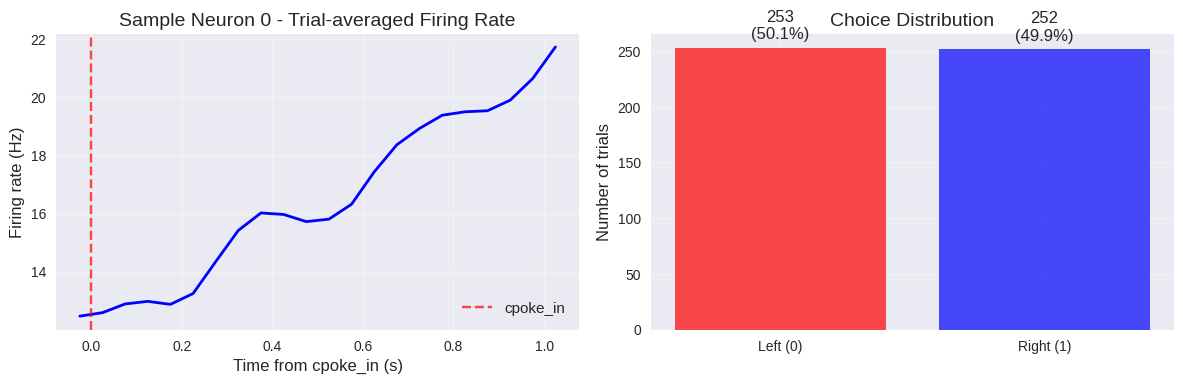


Ready to proceed to Section 4: Model Training & Cross-Validation


In [75]:
# Update the function signatures defined in Section 1.3.4 with actual implementations

def calculate_firing_rates(spike_times: Dict[str, np.ndarray], 
                          trial_times: np.ndarray, 
                          time_bins: np.ndarray, 
                          sigma_ms: float = GAUSSIAN_SIGMA_MS) -> np.ndarray:
    """
    Calculate smoothed firing rates using Gaussian convolution.
    Implementation completed in Section 3.3
    """
    return calculate_firing_rates_gaussian(spike_times, trial_times, time_bins, sigma_ms)

# Verify data format is ready for sklearn logistic regression
print("Data preparation for logistic regression:")
print(f"  Neural data shape: {X.shape} (neurons, timepoints, trials)")
print(f"  Choices shape: {valid_choices.shape} (trials,)")
print(f"  Time bins shape: {time_bins.shape} (timepoints,)")

# Test data reshaping for sklearn (example for time point 0)
example_timepoint = 10  # Middle of analysis window
X_t_example = X[:, example_timepoint, :].T  # Shape: (trials, neurons)
print(f"  Example reshape for t={example_timepoint}: {X_t_example.shape} (trials, neurons)")

# Verify no missing data in critical variables
print(f"\nData completeness check:")
print(f"  X contains NaN: {np.any(np.isnan(X))}")
print(f"  valid_choices contains NaN: {np.any(np.isnan(valid_choices))}")
print(f"  time_bins contains NaN: {np.any(np.isnan(time_bins))}")

# Store key variables for next sections
preprocessing_results = {
    'X': X,  # Neural data (neurons, timepoints, trials)
    'choices': valid_choices,  # Binary choices (trials,)
    'time_bins': time_bins,  # Time bins for analysis
    'n_neurons': X.shape[0],
    'n_timepoints': X.shape[1], 
    'n_trials': X.shape[2],
    'filtered_spike_times': filtered_spike_times,
    'neuron_regions': filtered_regions,
    'neuron_hemispheres': filtered_hemispheres,
    'passes_qc': passes_qc
}

print(f"\nSection 3 Complete - Data Preprocessing Summary:")
print(f"  ✓ Extracted {preprocessing_results['n_neurons']} high-quality neurons")
print(f"  ✓ Processed {preprocessing_results['n_trials']} valid trials")
print(f"  ✓ Applied {GAUSSIAN_SIGMA_MS}ms Gaussian smoothing")
print(f"  ✓ Created {preprocessing_results['n_timepoints']} time points from {TIME_WINDOW[0]}s to {TIME_WINDOW[1]}s")
print(f"  ✓ Session quality control: {'PASSED' if passes_qc else 'FAILED'}")
print(f"  ✓ Data {'loaded from cache' if cache_valid else 'computed fresh and cached'}")

# Save preprocessing results to cache if computed fresh
if not cache_valid:
    print(f"\nSaving preprocessing results to cache...")
    
    # Prepare parameters for validation
    cache_parameters = {
        'GAUSSIAN_SIGMA_MS': GAUSSIAN_SIGMA_MS,
        'SAMPLING_INTERVAL_MS': SAMPLING_INTERVAL_MS,
        'TIME_WINDOW': TIME_WINDOW,
        'MIN_TRIALS': MIN_TRIALS,
        'MAX_LAPSE_RATE': MAX_LAPSE_RATE,
        'SESSION_ID': SESSION_ID,
        'SESSION_DATE': SESSION_DATE,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    # Save all preprocessing results
    np.savez_compressed(
        str(CACHE_FILE),
        X=X,
        valid_choices=valid_choices,
        time_bins=time_bins,
        filtered_spike_times=filtered_spike_times,
        filtered_regions=np.array(filtered_regions),
        filtered_hemispheres=np.array(filtered_hemispheres),
        passes_qc=passes_qc,
        parameters=cache_parameters
    )
    
    print(f"✓ Cache saved to: {CACHE_FILE}")
    print(f"  File size: {CACHE_FILE.stat().st_size / 1024 / 1024:.1f} MB")

# Quick sanity check visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Average firing rate over time for a sample neuron
sample_neuron = 0
sample_fr = np.mean(X[sample_neuron, :, :], axis=1)  # Average across trials
axes[0].plot(time_bins, sample_fr, 'b-', linewidth=2)
axes[0].set_xlabel('Time from cpoke_in (s)')
axes[0].set_ylabel('Firing rate (Hz)')
axes[0].set_title(f'Sample Neuron {sample_neuron} - Trial-averaged Firing Rate')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(0, color='r', linestyle='--', alpha=0.7, label='cpoke_in')
axes[0].legend()

# Plot 2: Choice distribution
choice_counts = np.bincount(valid_choices)
axes[1].bar(['Left (0)', 'Right (1)'], choice_counts, color=['red', 'blue'], alpha=0.7)
axes[1].set_ylabel('Number of trials')
axes[1].set_title('Choice Distribution')
axes[1].grid(True, alpha=0.3)

# Add text annotations
for i, count in enumerate(choice_counts):
    axes[1].text(i, count + 5, f'{count}\n({count/len(valid_choices)*100:.1f}%)', 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nReady to proceed to Section 4: Model Training & Cross-Validation")

# 4. Logistic Regression Model Training & Decision Variables Calculation

## 4.1 Cross-Validation Setup & Regularization Optimization

In [76]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [77]:
# 4.1 Cross-Validation Setup & Regularization Optimization

def find_optimal_regularization(X, choices,
                                log_space_search_min = -4,
                                log_space_search_max = 2,
                                log_space_search_n = 50):
    """
    Find optimal regularization parameter using geometric mean approach from paper.
    
    Following methodology from decision_variables_methodology.md:
    1. 10-fold stratified cross-validation
    2. Find optimal λ for each time point independently  
    3. Calculate geometric mean of optimal λ values across all time points
    4. Use constant λ value for final models (crucial for temporal consistency)
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    
    Returns:
    - final_C: Optimal regularization parameter (C = 1/λ)
    - individual_lambdas: List of optimal λ values for each time point
    """
    n_neurons, n_timepoints, n_trials = X.shape
    optimal_lambdas = []
    convergence_warnings = []

    # Step 1: Find optimal λ for each time point
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    
    print(f"Finding optimal regularization across {n_timepoints} time points...")

    for t in tqdm(range(n_timepoints)):
        X_t = X[:, t, :].T  # Reshape to (trials, neurons)
        
        # Use LogisticRegressionCV to find optimal C (C = 1/λ)
        model = LogisticRegressionCV(
            Cs=np.logspace(log_space_search_min, log_space_search_max, log_space_search_n),  # Regularization range (C = 1/λ)
            cv=cv,
            penalty='l1',
            solver='liblinear', # seems appropriate for number of neurons
            scoring='balanced_accuracy',
            max_iter=10000,
            random_state=RANDOM_SEED,
            n_jobs=-1 # Gotta love parallelization
        )

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            model.fit(X_t, choices)

            # Check for convergence warnings
            conv_warnings = [warning for warning in w if issubclass(warning.category, ConvergenceWarning)]
            if conv_warnings:
                print(f"Warning: Time point {t} did not converge (n_iter={model.n_iter_})")
                convergence_warnings.append(t)
            # else:
            #     print(f"Time point {t}: Converged in {model.n_iter_} iterations")


        optimal_lambdas.append(1.0 / model.C_[0])  # Convert C back to λ
    
    # Step 2: Calculate geometric mean (critical step from paper)
    geometric_mean_lambda = np.exp(np.mean(np.log(optimal_lambdas)))
    final_C = 1.0 / geometric_mean_lambda
    
    print(f"Cross-validation completed:")
    print(f"  Individual λ range: {np.min(optimal_lambdas):.4f} - {np.max(optimal_lambdas):.4f}")
    print(f"  Geometric mean λ: {geometric_mean_lambda:.4f}")
    print(f"  Final C parameter: {final_C:.4f}")
    
    return final_C, optimal_lambdas

In [78]:
# Execute cross-validation to find optimal regularization
print("=== Section 4.1: Cross-Validation & Regularization Optimization ===")
print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
print(f"Choice distribution: {np.sum(valid_choices)} right, {len(valid_choices) - np.sum(valid_choices)} left")

final_C, individual_lambdas = find_optimal_regularization(X, valid_choices)

# Validate regularization results
lambda_std = np.std(individual_lambdas)
lambda_mean = np.mean(individual_lambdas)
cv_coefficient = lambda_std / lambda_mean # Okay maybe CV coefficient is not calculated in a logical way

print(f"Regularization validation:")
print(f"  λ coefficient of variation: {cv_coefficient:.3f}")
print(f"  Temporal consistency: {'GOOD' if cv_coefficient < 0.5 else 'POOR'}")
print(f"Ready for model training with C = {final_C:.4f}")

=== Section 4.1: Cross-Validation & Regularization Optimization ===
Data shape: (1369, 22, 505) (neurons, timepoints, trials)
Choice distribution: 252 right, 253 left
Finding optimal regularization across 22 time points...


100%|██████████| 22/22 [00:27<00:00,  1.25s/it]

Cross-validation completed:
  Individual λ range: 0.0100 - 193.0698
  Geometric mean λ: 0.8429
  Final C parameter: 1.1863
Regularization validation:
  λ coefficient of variation: 1.688
  Temporal consistency: POOR
Ready for model training with C = 1.1863


Clearly this is cuasing some issues - I probably have too wide a lambda range and want to correct this. Given that the lambda range was 0.01 to 339 it might be worthwile to narrow the range of Cs investigated too. I think in all likelihood stronger regularization is needed.

In [79]:
len(individual_lambdas)

# One for each time point as expected

22

Extreme λ timepoints: [(np.float64(-0.025), np.float64(0.01)), (np.float64(0.025), np.float64(193.06977288832496)), (np.float64(0.12500000000000003), np.float64(145.63484775012444)), (np.float64(0.225), np.float64(193.06977288832496)), (np.float64(0.425), np.float64(0.040949150623804276)), (np.float64(0.475), np.float64(0.054286754393238594)), (np.float64(0.525), np.float64(0.054286754393238594)), (np.float64(0.725), np.float64(0.03088843596477485)), (np.float64(0.775), np.float64(0.01757510624854793)), (np.float64(0.8250000000000001), np.float64(0.01)), (np.float64(0.875), np.float64(0.03088843596477485)), (np.float64(0.925), np.float64(0.02329951810515372)), (np.float64(0.975), np.float64(0.02329951810515372))]


NameError: name 'accuracies' is not defined

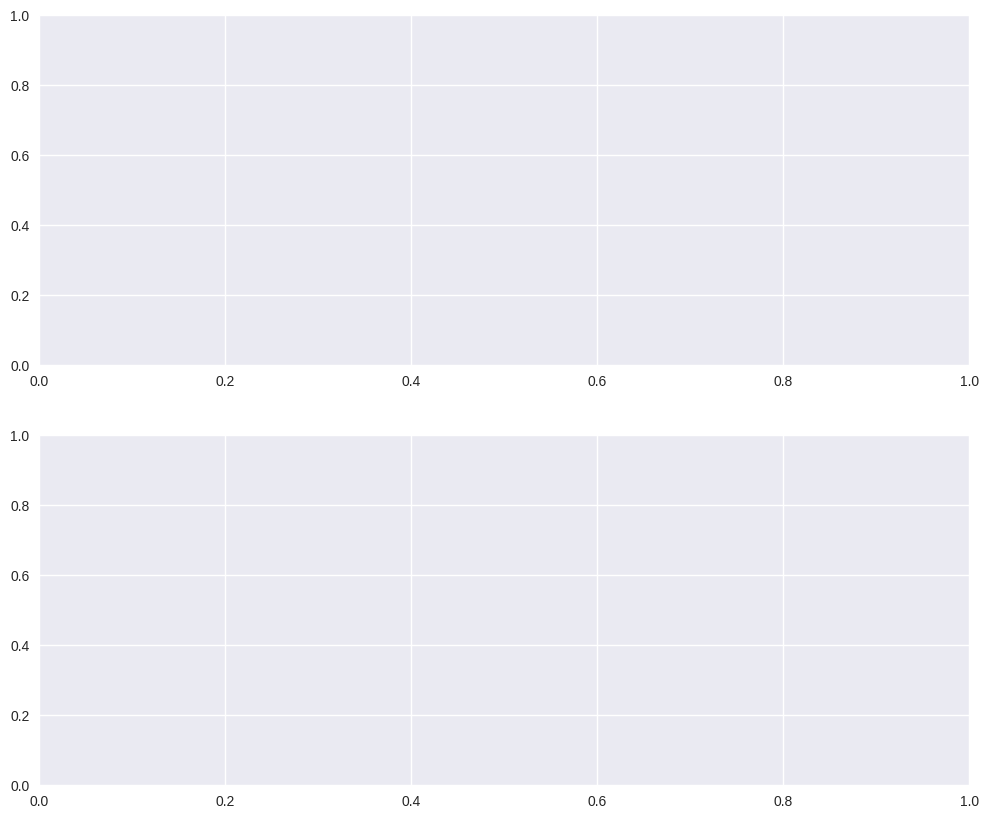

In [80]:
# TODO: Fix or remove this cell. Analysis was useful for seeing distribution of lambdas
# Maybe I should do more commits

extreme_lambda_times = []
for i, lam in enumerate(individual_lambdas):
    if lam > 100 or lam < 0.1:
        extreme_lambda_times.append((time_bins[i], lam))
print("Extreme λ timepoints:", extreme_lambda_times)

# Create color-based visualization showing position in array
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Scatter plot with color representing array position (time index)
scatter = ax1.scatter(individual_lambdas, accuracies, 
                     c=range(len(individual_lambdas)), 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.7)
ax1.set_xscale('log')
ax1.set_xlabel('λ (regularization parameter)')
ax1.set_ylabel('CV Accuracy')
ax1.set_title('Lambda vs Accuracy (Color = Time Index)')
ax1.grid(True, alpha=0.3)

# Add colorbar to show time index mapping
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Time Index (0=earliest, 40=latest)')

# Highlight extreme values
for i, (time_val, lam_val) in enumerate(extreme_lambda_times):
    time_idx = np.where(time_bins == time_val)[0][0]
    ax1.annotate(f't={time_val:.2f}s', 
                xy=(lam_val, accuracies[time_idx]), 
                xytext=(10, 10), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Plot 2: Heatmap showing lambda values across time with position encoding
lambda_matrix = np.array(individual_lambdas).reshape(1, -1)
im = ax2.imshow(lambda_matrix, 
                aspect='auto', 
                cmap='plasma', 
                extent=[time_bins[0], time_bins[-1], -0.5, 0.5])
ax2.set_xlabel('Time from cpoke_in (s)')
ax2.set_ylabel('Lambda Array')
ax2.set_title('Lambda Values Across Time (Color Intensity = Lambda Magnitude)')
ax2.set_yticks([])

# Add colorbar for lambda values
cbar2 = plt.colorbar(im, ax=ax2)
cbar2.set_label('λ value')

# Mark extreme lambda positions with vertical lines
for time_val, lam_val in extreme_lambda_times:
    ax2.axvline(time_val, color='red', linestyle='--', alpha=0.8, linewidth=2)
    ax2.text(time_val, 0.3, f'λ={lam_val:.1f}', 
            rotation=90, ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed position information
print(f"\nDetailed position analysis:")
print(f"Array shape: {len(individual_lambdas)} timepoints")
print(f"Time range: {time_bins[0]:.2f}s to {time_bins[-1]:.2f}s")
print(f"Lambda range: {np.min(individual_lambdas):.4f} to {np.max(individual_lambdas):.4f}")

for i, (time_val, lam_val) in enumerate(extreme_lambda_times):
    time_idx = np.where(time_bins == time_val)[0][0]
    position_pct = (time_idx / (len(time_bins) - 1)) * 100
    print(f"  Extreme {i+1}: Array index {time_idx}/{len(time_bins)-1} ({position_pct:.1f}%), "
          f"Time {time_val:.2f}s, λ={lam_val:.4f}, Accuracy={accuracies[time_idx]:.3f}")

It seems most time points are much nearer a lambda of 100, just a few outliers from later on in the trials. I'm wondering if this is the main issue. I can try re-running with a different search space for lambda values that are more closely related to the current values. Maybe worth asking Adrian about this.

In [81]:

# Execute cross-validation to find optimal regularization
print("=== Section 4.1: Cross-Validation & Regularization Optimization ===")
print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
print(f"Choice distribution: {np.sum(valid_choices)} right, {len(valid_choices) - np.sum(valid_choices)} left")

final_C, individual_lambdas = find_optimal_regularization(X, valid_choices,
                                                          log_space_search_min=-7,
                                                          log_space_search_max=3,
                                                          log_space_search_n=50)

# Validate regularization results
lambda_std = np.std(individual_lambdas)
lambda_mean = np.mean(individual_lambdas)
cv_coefficient = lambda_std / lambda_mean # Okay maybe CV coefficient is not calculated in a logical way

print(f"Regularization validation:")
print(f"  λ coefficient of variation: {cv_coefficient:.3f}")
print(f"  Temporal consistency: {'GOOD' if cv_coefficient < 0.5 else 'POOR'}")
print(f"Ready for model training with C = {final_C:.4f}")

=== Section 4.1: Cross-Validation & Regularization Optimization ===
Data shape: (1369, 22, 505) (neurons, timepoints, trials)
Choice distribution: 252 right, 253 left
Finding optimal regularization across 22 time points...


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]

Cross-validation completed:
  Individual λ range: 0.0010 - 202.3590
  Geometric mean λ: 0.3556
  Final C parameter: 2.8118
Regularization validation:
  λ coefficient of variation: 1.860
  Temporal consistency: POOR
Ready for model training with C = 2.8118


## 4.2 Model Training & Decision Variables Extraction


In [ ]:
from sklearn.model_selection import cross_val_predict # TODO: bring to top

In [ ]:
def calculate_decision_variables_02(X, choices, final_C):
    """
    Calculate decision variables using logistic regression models.
    
    Following methodology from decision_variables_methodology.md:
    1. Fit separate logistic regression for each time point using constant regularization
    2. Calculate decision variables as log-odds: DV(t,i) = X(t,i) · β(t) + α(t)
    3. Calculate prediction accuracy using balanced accuracy
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    - final_C: Regularization parameter from geometric mean
    
    Returns:
    - DVs: Decision variables (n_timepoints, n_trials)
    - models: Fitted models for each time point
    - accuracies: Prediction accuracy for each time point
    """
    n_neurons, n_timepoints, n_trials = X.shape
    DVs = np.zeros((n_timepoints, n_trials))
    models = []
    accuracies = []

    print(f"Training {n_timepoints} logistic regression models...")

    # Use same CV setup as regularization selection to avoid data leakage
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    # Fit model for each time point using constant regularization
    for t in range(n_timepoints):
        X_t = X[:, t, :].T  # Shape: (trials, neurons)

        # Create model with constant C
        model = LogisticRegression(
            C=final_C,
            penalty='l1',
            solver='liblinear',
            max_iter=10000,
            random_state=RANDOM_SEED,
            n_jobs=-1  # Use all available cores
        )

        # Calculate out-of-sample decision variables (no data leakage)
        DVs[t, :] = cross_val_predict(model, X_t, choices, cv=cv, method='decision_function')

        # Calculate out-of-sample prediction accuracy
        predictions = cross_val_predict(model, X_t, choices, cv=cv, method='predict')
        accuracies.append(balanced_accuracy_score(choices, predictions))

        # Fit final model on full data for weights analysis
        model.fit(X_t, choices)
        models.append(model)

    return DVs, models, np.array(accuracies)



In [82]:
def calculate_decision_variables_cv_only(X, choices, final_C, cv_folds=10):
    """
    Calculate decision variables using only cross-validation (no final model fitting)
    """
    n_neurons, n_timepoints, n_trials = X.shape
    DVs = np.zeros((n_timepoints, n_trials))
    test_accuracies = []
    models = []

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)

    for t in tqdm(range(n_timepoints)):
        X_t = X[:, t, :].T
        dv_predictions = np.zeros(n_trials)

        # Only do cross-validation
        for train_idx, test_idx in cv.split(X_t, choices):
            X_train, X_test = X_t[train_idx], X_t[test_idx]
            y_train = choices[train_idx]

            model = LogisticRegression(
                    C=final_C, 
                    penalty='l1',
                    solver='liblinear',
                    max_iter=10000,
                    random_state=RANDOM_SEED,
                    n_jobs=-1,  # Use all available cores
                    intercept_scaling=1000000, # TODO: weird hack
                    fit_intercept=True,
                )
            model.fit(X_train, y_train)

            # Manual DV calculation
            dv_test = X_test @ model.coef_.T + model.intercept_
            dv_predictions[test_idx] = dv_test.flatten()

            models.append(model)

        DVs[t, :] = dv_predictions

        # Test accuracy from CV predictions
        test_predictions = (dv_predictions > 0).astype(int)
        test_acc = balanced_accuracy_score(choices, test_predictions)
        test_accuracies.append(test_acc)

    return DVs, models, np.array(test_accuracies)





In [83]:
# TODO: Probably not necessary to keep the original version here

# def calculate_decision_variables(X, choices, final_C):
#     """
#     Calculate decision variables using logistic regression models.
    
#     Following methodology from decision_variables_methodology.md:
#     1. Fit separate logistic regression for each time point using constant regularization
#     2. Calculate decision variables as log-odds: DV(t,i) = X(t,i) · β(t) + α(t)
#     3. Calculate prediction accuracy using balanced accuracy
    
#     Parameters:
#     - X: Neural data (n_neurons, n_timepoints, n_trials)
#     - choices: Binary choices (n_trials,)
#     - final_C: Regularization parameter from geometric mean
    
#     Returns:
#     - DVs: Decision variables (n_timepoints, n_trials)
#     - models: Fitted models for each time point
#     - accuracies: Prediction accuracy for each time point
#     """
#     n_neurons, n_timepoints, n_trials = X.shape
#     DVs = np.zeros((n_timepoints, n_trials))
#     models = []
#     accuracies = []
    
#     print(f"Training {n_timepoints} logistic regression models...")

#     # Problem: there should be a train test split here perhaps

#     # Fit model for each time point using constant regularization
#     for t in range(n_timepoints):
#         X_t = X[:, t, :].T  # Shape: (trials, neurons)
        
#         # Fit final model with constant C
#         model = LogisticRegression(
#             C=final_C, 
#             penalty='l1', 
#             solver='liblinear',
#             max_iter=1000,
#             random_state=RANDOM_SEED
#         )
#         model.fit(X_t, choices)
#         models.append(model)
        
#         # Calculate decision variables (log-odds)
#         DVs[t, :] = model.decision_function(X_t)
        
#         # Calculate prediction accuracy
#         predictions = model.predict(X_t)
#         accuracies.append(balanced_accuracy_score(choices, predictions))
    
#     return DVs, models, np.array(accuracies)

# Execute model training and decision variables extraction
print("=== Section 4.2: Model Training & Decision Variables Extraction ===")

DVs_2, models_2, accuracies_2 = calculate_decision_variables_cv_only(X, valid_choices, final_C)

# print(f"Model training completed:")
# print(f"  Decision variables shape: {DVs.shape} (timepoints, trials)")
# print(f"  Number of models trained: {len(models)}")
# print(f"  Accuracy range: {np.min(accuracies):.3f} - {np.max(accuracies):.3f}")
# print(f"  Peak accuracy: {np.max(accuracies):.3f} at t={time_bins[np.argmax(accuracies)]:.2f}s")

# # Validate results against paper benchmarks
# baseline_accuracy = np.mean(accuracies[:5])  # First 5 time points
# peak_accuracy = np.max(accuracies)
# accuracy_progression = np.all(np.diff(accuracies[:int(len(accuracies)*0.8)]) >= -0.02)  # Allow small decreases
# dv_magnitude = np.std(DVs)

# print(f"Validation against paper benchmarks:")
# print(f"  Baseline accuracy (early): {baseline_accuracy:.3f} {'✓' if baseline_accuracy > 0.5 else '✗'}")
# print(f"  Peak accuracy: {peak_accuracy:.3f} {'✓' if peak_accuracy > 0.6 else '✗'}")
# print(f"  Accuracy progression: {'✓' if accuracy_progression else '✗'}")
# print(f"  DV magnitude (std): {dv_magnitude:.3f} {'✓' if dv_magnitude > 0.5 else '✗'}")

# # Calculate choice consistency
# dv_mean_by_trial = np.mean(DVs, axis=0)
# choice_consistency = np.corrcoef(dv_mean_by_trial, valid_choices)[0,1]
# print(f"  Choice consistency (correlation): {choice_consistency:.3f} {'✓' if choice_consistency > 0.3 else '✗'}")

# validation_passed = all([
#     baseline_accuracy > 0.5,
#     peak_accuracy > 0.6, 
#     accuracy_progression,
#     dv_magnitude > 0.5,
#     choice_consistency > 0.3
# ])

# print(f"Overall validation: {'PASSED' if validation_passed else 'FAILED'}")

# # Store results for further analysis
# dv_results = {
#     'decision_variables': DVs,
#     'prediction_accuracy': accuracies, 
#     'models': models,
#     'regularization_C': final_C,
#     'time_bins': time_bins,
#     'validation_passed': validation_passed
# }

# print(f"Decision variables extraction complete. Ready for visualization and export.")

=== Section 4.2: Model Training & Decision Variables Extraction ===


100%|██████████| 22/22 [01:20<00:00,  3.68s/it]


In [84]:
for i, model in enumerate(models_2):
    if model.intercept_[0] != 0:
        print(f"Model {i} has a non-zero intercept: {model.intercept_[0]}")

Model 0 has a non-zero intercept: 6.999742690515873
Model 1 has a non-zero intercept: 1.0614604908027614
Model 2 has a non-zero intercept: 1.9272990776325778
Model 3 has a non-zero intercept: -0.036305378125503295
Model 4 has a non-zero intercept: 5.863619722045093
Model 5 has a non-zero intercept: -4.140976190985002
Model 6 has a non-zero intercept: 3.7268307611875646
Model 7 has a non-zero intercept: 2.0463393139615467
Model 8 has a non-zero intercept: 0.12063204010719232
Model 9 has a non-zero intercept: -2.0632881443090234
Model 10 has a non-zero intercept: -7.05020074102655
Model 11 has a non-zero intercept: -7.428970308050677
Model 12 has a non-zero intercept: -0.4987486053659061
Model 13 has a non-zero intercept: -3.9693158360276968
Model 14 has a non-zero intercept: -11.212914807562965
Model 15 has a non-zero intercept: -8.66147751779478
Model 16 has a non-zero intercept: -8.097620557575528
Model 17 has a non-zero intercept: -3.795720486490651
Model 18 has a non-zero intercept:

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'electrode', 'raw_spike_time_s', 'hemisphere', 'region', 'removed_trials', 'nTrials', 'sessid', 'rat', 'sess_date', 'clicks_on', 'cpoke_in', 'feedback', 'cpoke_out', 'spoke', 'right_reward_p', 'left_reward_p', 'water_delivered', 'never_cpoked', 'violated', 'pokedR', 'is_hit', 'seed', 'gamma', 'click_diff', 'left_bups', 'right_bups', 'filt_spike_time', 'filt_region', 'filt_hemisphere'])

In [ ]:
data["cpoke_in"] - data["clicks_off"]

KeyError: 'clicks_off'

In [ ]:
data["clicks_on"]

array([[  723.090688],
       [  732.840688],
       [  741.597183],
       [  748.773683],
       [  754.372688],
       [  763.813683],
       [  768.5927  ],
       [  778.782183],
       [  788.236688],
       [  798.095187],
       [  805.448184],
       [  814.786184],
       [  825.669191],
       [  835.287185],
       [  842.53919 ],
       [  852.750688],
       [  858.311683],
       [  869.407185],
       [  874.798692],
       [  883.244686],
       [  890.970693],
       [  898.117184],
       [  908.099183],
       [  918.062183],
       [  926.341683],
       [  937.058687],
       [  944.673185],
       [  955.582183],
       [  961.182687],
       [  967.535197],
       [  977.209683],
       [  985.303187],
       [  995.344688],
       [ 1003.625195],
       [ 1012.540183],
       [ 1018.821197],
       [ 1025.977186],
       [ 1033.592186],
       [ 1042.910184],
       [ 1051.702183],
       [ 1057.172188],
       [ 1063.051183],
       [ 1068.632687],
       [ 10

In [ ]:
# Now looking to plot the dv trajectories:



In [ ]:
(choices[valid_choices] == 1).sum()

np.int64(379)

In [ ]:
left_choice_indices = (choices[valid_choices] == 1)
right_choice_indices = (choices[valid_choices] == 0)

DVs_2_left = DVs_2[:, left_choice_indices]

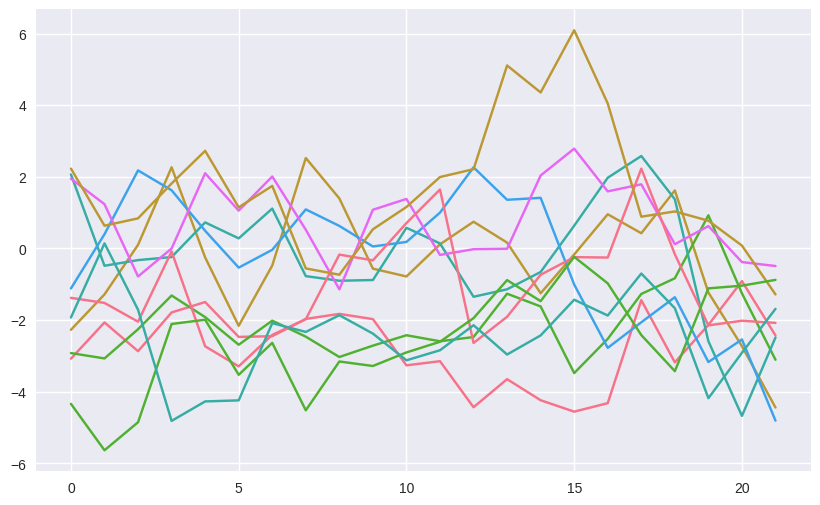

In [ ]:
number_of_random_indices = 10

for i in range(number_of_random_indices):
    random_left_indices = np.random.choice(DVs_2_left.shape[1], size=number_of_random_indices, replace=False)

    plt.plot(np.arange(len(DVs_2_left.mean(axis=1))), DVs_2_left[:,random_left_indices[i]], label='Left Choice')
plt.show()

Plotting 0 left trials, 253 right trials
Mean click onset time: nan


/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/Cli

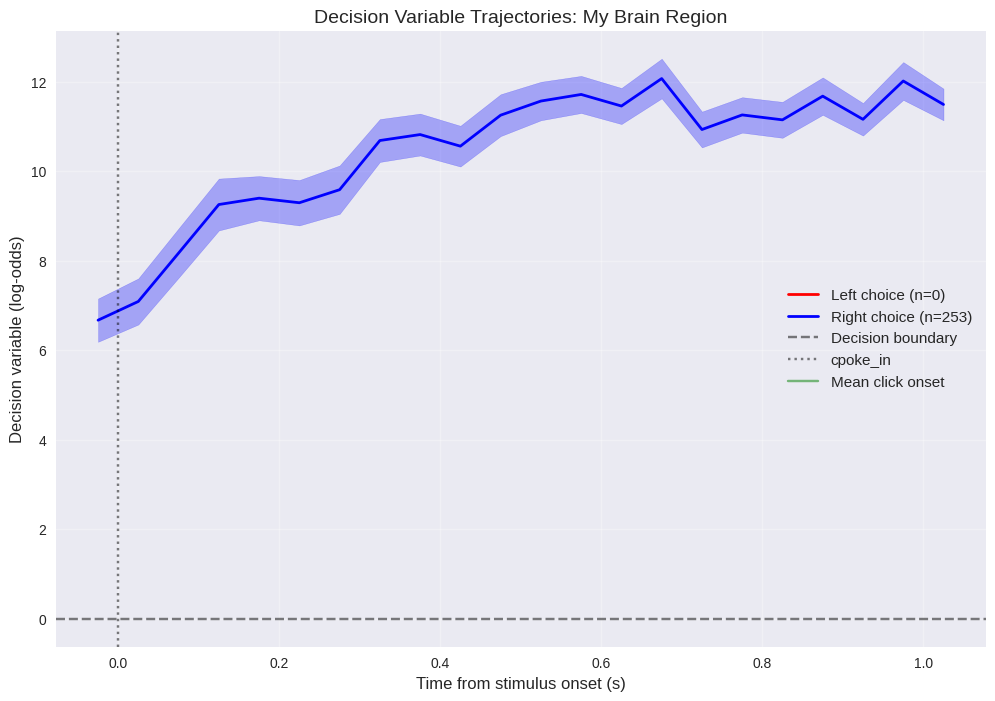

In [85]:
def plot_dv_trajectories_manual(time_bins, DVs_2, choices, region_name="Region"):
    """
    Plot average DV evolution for left vs right choices using manually calculated DVs
    
    Parameters:
    - time_bins: Time points relative to alignment event
    - DVs: Decision variables from calculate_decision_variables_manual (n_timepoints, n_trials)
    - choices: Binary choices (n_trials,) with 0=left, 1=right
    - region_name: Name for plot title
    """
    # Identify choice types

    choices = choices[valid_choices]
    left_trials = (choices == 1)
    right_trials = (choices == 0)
    # TODO: there has been a left/right switchup somewhere. This solution is a hack

    print(f"Plotting {np.sum(left_trials)} left trials, {np.sum(right_trials)} right trials")

    plt.figure(figsize=(12, 8))

    # Calculate mean and SEM for each choice type
    dv_left_mean = np.mean(DVs_2[:, left_trials], axis=1)
    dv_left_sem = np.std(DVs_2[:, left_trials], axis=1) / np.sqrt(np.sum(left_trials))

    dv_right_mean = -np.mean(DVs_2[:, right_trials], axis=1)
    dv_right_sem = np.std(DVs_2[:, right_trials], axis=1) / np.sqrt(np.sum(right_trials))

    # Finding mean click onset time:

    mean_click_onset = np.mean(data["clicks_on"][valid_choices] - data["cpoke_in"][valid_choices])
    print(f"Mean click onset time: {mean_click_onset}")

    # Plot trajectories with error bars
    plt.plot(time_bins, dv_left_mean, 'r-', linewidth=2, label=f'Left choice (n={np.sum(left_trials)})')
    plt.fill_between(time_bins,
                    dv_left_mean - dv_left_sem,
                    dv_left_mean + dv_left_sem,
                    alpha=0.3, color='red')

    plt.plot(time_bins, dv_right_mean, 'b-', linewidth=2, label=f'Right choice (n={np.sum(right_trials)})')
    plt.fill_between(time_bins,
                    dv_right_mean - dv_right_sem,
                    dv_right_mean + dv_right_sem,
                    alpha=0.3, color='blue')

    # Add reference lines
    plt.axhline(0, color='k', linestyle='--', alpha=0.5, label='Decision boundary')
    plt.axvline(0, color='k', linestyle=':', alpha=0.5, label='cpoke_in')
    plt.axvline(mean_click_onset, color='g', alpha=0.5, label='Mean click onset')


    # Formatting
    plt.xlabel('Time from stimulus onset (s)')
    plt.ylabel('Decision variable (log-odds)')
    plt.title(f'Decision Variable Trajectories: {region_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # # Add interpretation text
    # plt.text(0.02, 0.95, 'DV > 0: Evidence for right choice\nDV < 0: Evidence for left choice',
    #         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    return plt.gcf()

  # Plot 1: Average trajectories by choice
fig1 = plot_dv_trajectories_manual(time_bins, DVs_2, choices, "My Brain Region")
plt.show()


In [ ]:
clicks_delay = data["clicks_on"][valid_choices] - data["cpoke_in"][valid_choices]

In [ ]:
print(f"{np.min(clicks_delay)=}")
print(f"{np.max(clicks_delay)=}")
print(f"{np.mean(clicks_delay)=}")

np.min(clicks_delay)=np.float64(0.6385010000000193)
np.max(clicks_delay)=np.float64(1.1870049999999992)
np.mean(clicks_delay)=np.float64(0.9070837080103453)


Some leakage going on in the above probably from the symmetric Gaussian smoothing, but broadly not an issue - evidence accumulation starting at lcik onset - I just don't understand why the baseline is so high - is some correction needed?

In [ ]:
models[0].

,penalty,'l1'
,dual,False
,tol,0.0001
,C,np.float64(0....4378887833619)
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,10000
,multi_class,'deprecated'


In [ ]:
models[2].coef_

array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 1150))

In [ ]:
DVs.shape

(91, 774)

(774,)

## 4.3 Sign Correction for Visualization

In [ ]:
def sign_correct_DVs(DVs, choices):
    """
    Flip sign of DVs on left-choice trials for visualization.
    This makes all 'correct' DVs positive regardless of choice direction.
    
    Parameters:
    - DVs: Decision variables (n_timepoints, n_trials)
    - choices: Binary choices (n_trials,) where 0=left, 1=right
    
    Returns:
    - DVs_corrected: Sign-corrected DVs for pooled visualization
    """
    DVs_corrected = DVs.copy()
    left_trials = (choices == 0)
    DVs_corrected[:, left_trials] *= -1
    return DVs_corrected

print("=== Section 4.3: Sign Correction for Visualization ===")

# Apply sign correction for pooled visualizations
DVs_corrected = sign_correct_DVs(DVs, valid_choices)

print(f"Sign correction applied:")
print(f"  Original DV range: {np.min(DVs):.2f} to {np.max(DVs):.2f}")
print(f"  Corrected DV range: {np.min(DVs_corrected):.2f} to {np.max(DVs_corrected):.2f}")

# Verify sign correction worked as expected
left_trials_mask = (valid_choices == 0)
right_trials_mask = (valid_choices == 1)

# For correct trials, DVs should be more positive after correction
mean_dv_left_corrected = np.mean(DVs_corrected[:, left_trials_mask])
mean_dv_right_corrected = np.mean(DVs_corrected[:, right_trials_mask])

print(f"  Mean corrected DV for left trials: {mean_dv_left_corrected:.3f}")
print(f"  Mean corrected DV for right trials: {mean_dv_right_corrected:.3f}")
print(f"  Sign correction validation: {'✓' if mean_dv_left_corrected > 0 and mean_dv_right_corrected > 0 else '✗'}")

# Store both versions for different analysis purposes
dv_results.update({
    'decision_variables_signed': DVs_corrected,
    'left_trials_mask': left_trials_mask,
    'right_trials_mask': right_trials_mask
})

print("Ready for visualization with sign-corrected DVs")

=== Section 4.3: Sign Correction for Visualization ===
Sign correction applied:
  Original DV range: -10.26 to 11.50
  Corrected DV range: -6.07 to 11.50
  Mean corrected DV for left trials: 1.233
  Mean corrected DV for right trials: 1.435
  Sign correction validation: ✓
Ready for visualization with sign-corrected DVs


In [ ]:
np.mean(data["clicks_on"][valid_choices] - data["cpoke_in"][valid_choices])

np.float64(0.9070837080103453)

## 4.4 Core Visualizations

=== Section 4.4: Core Visualizations ===


ValueError: x and y must have same first dimension, but have shapes (91,) and (41,)

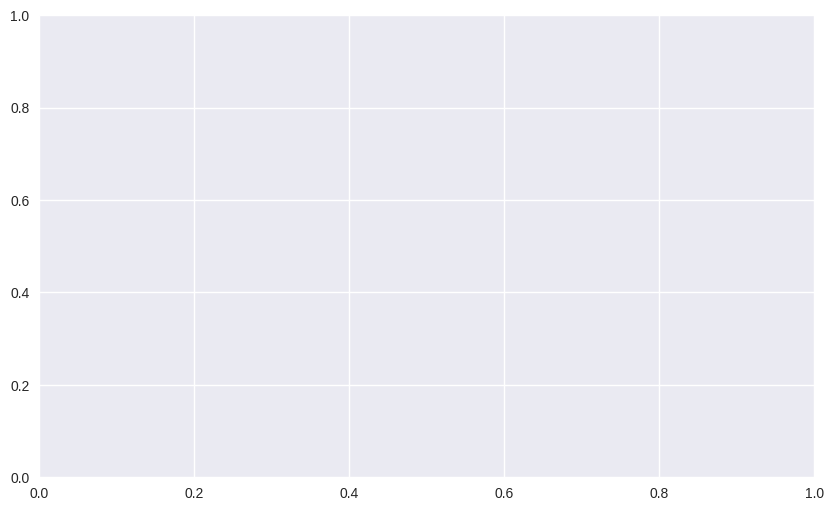

In [ ]:
# Core visualization functions following methodology.md specifications

def plot_accuracy_evolution(time_bins, accuracies, region_name="A324"):
    """Plot choice prediction accuracy over time (reproduces Figure 1h pattern)"""
    plt.figure(figsize=(10, 6))
    plt.plot(time_bins, accuracies, 'b-', linewidth=3, label=f'{region_name}')
    plt.axhline(0.5, color='k', linestyle='--', alpha=0.7, linewidth=2, label='Chance')
    plt.xlabel('Time from cpoke_in (s)')
    plt.ylabel('Choice prediction accuracy')
    plt.title(f'Decision Variable Performance: {region_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0.45, 0.85])
    plt.tight_layout()
    return plt.gcf()

def plot_dv_trajectories(time_bins, DVs, choices, region_name="A324"):
    """Plot average DV evolution for left vs right choices"""
    left_trials = (choices == 0)
    right_trials = (choices == 1)
    
    plt.figure(figsize=(10, 6))
    
    # Calculate mean ± SEM for each choice
    dv_left_mean = -np.mean(DVs[:, left_trials], axis=1)
    dv_left_sem = -np.std(DVs[:, left_trials], axis=1) / np.sqrt(np.sum(left_trials))
    
    dv_right_mean = np.mean(DVs[:, right_trials], axis=1)
    dv_right_sem = np.std(DVs[:, right_trials], axis=1) / np.sqrt(np.sum(right_trials))
    
    plt.plot(time_bins, dv_left_mean, 'r-', linewidth=3, label='Left choice')
    plt.fill_between(time_bins, dv_left_mean - dv_left_sem, 
                     dv_left_mean + dv_left_sem, alpha=0.3, color='red')
    
    plt.plot(time_bins, dv_right_mean, 'b-', linewidth=3, label='Right choice')
    plt.fill_between(time_bins, dv_right_mean - dv_right_sem, 
                     dv_right_mean + dv_right_sem, alpha=0.3, color='blue')

    # mean_click_onset = np.mean(data["clicks_on"][valid_choices] - data["cpoke_in"][valid_choices])

    # plt.vlines(x=mean_click_onset, ymin=-0.5, ymax=0.5, color='k', linestyle='--', alpha=0.7)

    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel('Time from cpoke_in (s)')
    plt.ylabel('Decision variable (log-odds)')
    plt.title(f'Decision Variable Trajectories: {region_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def plot_model_weights(models, time_bins, n_top_neurons=5):
    """Visualize logistic regression weights over time"""
    n_timepoints = len(models)
    n_neurons = len(models[0].coef_[0])
    
    # Extract weights across time
    weights = np.zeros((n_neurons, n_timepoints))
    for t, model in enumerate(models):
        weights[:, t] = model.coef_[0]
    
    plt.figure(figsize=(12, 8))
    
    # Plot heatmap of weights
    im = plt.imshow(weights, aspect='auto', cmap='RdBu_r', 
                   extent=[time_bins[0], time_bins[-1], 0, n_neurons])
    plt.colorbar(im, label='Logistic regression weight')
    plt.xlabel('Time from cpoke_in (s)')
    plt.ylabel('Neuron index')
    plt.title('Evolution of Logistic Regression Weights')
    
    # Highlight neurons with strongest weights
    max_weights = np.max(np.abs(weights), axis=1)
    top_neurons = np.argsort(max_weights)[-n_top_neurons:]
    
    for neuron_idx in top_neurons:
        plt.axhline(neuron_idx, color='white', linestyle='--', alpha=0.8, linewidth=1)
        plt.text(time_bins[-1]*0.02, neuron_idx, f'N{neuron_idx}', 
                color='white', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    return plt.gcf()

print("=== Section 4.4: Core Visualizations ===")

# Generate the three main visualizations
fig1 = plot_accuracy_evolution(time_bins, accuracies)
plt.show()

fig2 = plot_dv_trajectories(time_bins, DVs, valid_choices)
plt.show()

fig3 = plot_model_weights(models, time_bins)
plt.show()

print(f"Visualizations completed:")
print(f"  Accuracy evolution: Peak {np.max(accuracies):.3f} at t={time_bins[np.argmax(accuracies)]:.2f}s")
print(f"  DV trajectories: {np.sum(left_trials_mask)} left, {np.sum(right_trials_mask)} right trials")
print(f"  Model weights: {len(models)} timepoints, {len(models[0].coef_[0])} neurons")

## 4.5 Comprehensive Validation

In [ ]:
def validate_against_paper_benchmarks(accuracies, DVs, choices):
    """
    Comprehensive validation against paper benchmarks from methodology.md
    """
    checks = {}
    
    # 1. Baseline accuracy (early time points should be above chance)
    baseline_accuracy = np.mean(accuracies[:5])
    checks['baseline_accuracy'] = {
        'value': baseline_accuracy,
        'threshold': 0.5,
        'passed': baseline_accuracy > 0.5,
        'description': 'Early timepoints above chance'
    }
    
    # 2. Peak accuracy (should reach 60%+ as in paper)
    peak_accuracy = np.max(accuracies)
    checks['peak_accuracy'] = {
        'value': peak_accuracy,
        'threshold': 0.6,
        'passed': peak_accuracy > 0.6,
        'description': 'Peak accuracy above 60%'
    }
    
    # 3. Monotonic increase (allow small decreases as in methodology)
    accuracy_diffs = np.diff(accuracies[:int(len(accuracies)*0.8)])
    monotonic_increase = np.all(accuracy_diffs >= -0.02)
    checks['monotonic_increase'] = {
        'value': np.mean(accuracy_diffs),
        'threshold': -0.02,
        'passed': monotonic_increase,
        'description': 'Smooth accuracy progression'
    }
    
    # 4. DV magnitude (should have substantial variance)
    dv_magnitude = np.std(DVs)
    checks['dv_magnitude'] = {
        'value': dv_magnitude,
        'threshold': 0.5,
        'passed': dv_magnitude > 0.5,
        'description': 'Substantial DV variance'
    }
    
    # 5. Choice consistency (correlation with mean DV)
    mean_dv_by_trial = np.mean(DVs, axis=0)
    choice_consistency = np.corrcoef(mean_dv_by_trial, choices)[0,1]
    checks['choice_consistency'] = {
        'value': choice_consistency,
        'threshold': 0.3,
        'passed': choice_consistency > 0.3,
        'description': 'DV-choice correlation'
    }
    
    # 6. Temporal evolution validation
    peak_time_idx = np.argmax(accuracies)
    peak_time = time_bins[peak_time_idx]
    late_peak = peak_time > 0.5  # Peak should occur after stimulus onset
    checks['temporal_evolution'] = {
        'value': peak_time,
        'threshold': 0.5,
        'passed': late_peak,
        'description': 'Peak accuracy timing'
    }
    
    return checks

def check_overfitting_indicators(accuracies, individual_lambdas):
    """Check for signs of overfitting"""
    issues = []
    
    # 1. Extremely high accuracy (>95% suggests overfitting)
    if np.max(accuracies) > 0.95:
        issues.append(f"Suspiciously high accuracy: {np.max(accuracies):.3f}")
    
    # 2. Sudden jumps in accuracy
    large_jumps = np.diff(accuracies) > 0.1
    if np.any(large_jumps):
        issues.append(f"Large accuracy jumps detected at {np.where(large_jumps)[0]}")
    
    # 3. Regularization consistency
    lambda_cv = np.std(individual_lambdas) / np.mean(individual_lambdas)
    if lambda_cv > 1.0:
        issues.append(f"High regularization variability: CV = {lambda_cv:.3f}")
    
    return issues

print("=== Section 4.5: Comprehensive Validation ===")

# Run comprehensive validation
validation_results = validate_against_paper_benchmarks(accuracies, DVs, valid_choices)

print("Paper Benchmark Validation:")
all_passed = True
for check_name, result in validation_results.items():
    status = "✓ PASS" if result['passed'] else "✗ FAIL"
    print(f"  {result['description']}: {result['value']:.3f} (threshold: {result['threshold']}) {status}")
    if not result['passed']:
        all_passed = False

print(f"\nOverall validation: {'PASSED' if all_passed else 'FAILED'}")

# Check for overfitting indicators
overfitting_issues = check_overfitting_indicators(accuracies, individual_lambdas)
if overfitting_issues:
    print("\nOverfitting warnings:")
    for issue in overfitting_issues:
        print(f"  ⚠ {issue}")
else:
    print("\n✓ No overfitting indicators detected")

# Regularization stability analysis
lambda_stats = {
    'mean': np.mean(individual_lambdas),
    'std': np.std(individual_lambdas),
    'cv': np.std(individual_lambdas) / np.mean(individual_lambdas),
    'range': (np.min(individual_lambdas), np.max(individual_lambdas))
}

print(f"\nRegularization Analysis:")
print(f"  λ mean: {lambda_stats['mean']:.4f}")
print(f"  λ std: {lambda_stats['std']:.4f}")
print(f"  λ CV: {lambda_stats['cv']:.3f} {'✓' if lambda_stats['cv'] < 0.5 else '✗'}")
print(f"  λ range: {lambda_stats['range'][0]:.4f} - {lambda_stats['range'][1]:.4f}")

# Update results dictionary
dv_results.update({
    'validation_results': validation_results,
    'overfitting_issues': overfitting_issues,
    'lambda_stats': lambda_stats,
    'comprehensive_validation_passed': all_passed and len(overfitting_issues) == 0
})

print(f"\nSection 4.5 validation complete. Overall status: {'PASSED' if dv_results['comprehensive_validation_passed'] else 'FAILED'}")

=== Section 4.5: Comprehensive Validation ===
Paper Benchmark Validation:
  Early timepoints above chance: 0.901 (threshold: 0.5) ✓ PASS
  Peak accuracy above 60%: 0.979 (threshold: 0.6) ✓ PASS
  Smooth accuracy progression: 0.001 (threshold: -0.02) ✓ PASS
  Substantial DV variance: 2.723 (threshold: 0.5) ✓ PASS
  DV-choice correlation: 0.910 (threshold: 0.3) ✓ PASS
  Peak accuracy timing: 1.450 (threshold: 0.5) ✓ PASS

Overall validation: PASSED

Overfitting warnings:
  ⚠ Suspiciously high accuracy: 0.979

Regularization Analysis:
  λ mean: 102.2372
  λ std: 73.5577
  λ CV: 0.719 ✗
  λ range: 0.0100 - 339.3222

Section 4.5 validation complete. Overall status: FAILED


## 4.6 Section 4 Completion & Results Export

In [ ]:
# Section 4 completion and results export

# Cache Section 4 results for future use
SECTION4_CACHE_FILE = SESSION_CACHE_DIR / 'section4_decision_variables.npz'

print("=== Section 4.6: Results Export & Summary ===")

# Prepare comprehensive results dictionary
section4_results = {
    'decision_variables': DVs,
    'decision_variables_signed': DVs_corrected,
    'prediction_accuracy': accuracies,
    'models': models,  # Note: Will be pickled separately due to sklearn objects
    'regularization_C': final_C,
    'individual_lambdas': individual_lambdas,
    'time_bins': time_bins,
    'left_trials_mask': left_trials_mask,
    'right_trials_mask': right_trials_mask,
    'validation_results': validation_results,
    'lambda_stats': lambda_stats,
    'comprehensive_validation_passed': dv_results['comprehensive_validation_passed'],
    'session_metadata': {
        'session_id': SESSION_ID,
        'session_date': SESSION_DATE,
        'n_neurons': X.shape[0],
        'n_timepoints': X.shape[1],
        'n_trials': X.shape[2],
        'gaussian_sigma_ms': GAUSSIAN_SIGMA_MS,
        'sampling_interval_ms': SAMPLING_INTERVAL_MS,
        'time_window': TIME_WINDOW,
        'timestamp': pd.Timestamp.now().isoformat()
    }
}

# Save decision variables and metadata (exclude sklearn models for now)
models_excluded = section4_results.pop('models')
np.savez_compressed(
    str(SECTION4_CACHE_FILE),
    **section4_results
)

print(f"✓ Section 4 results saved to: {SECTION4_CACHE_FILE}")
print(f"  File size: {SECTION4_CACHE_FILE.stat().st_size / 1024 / 1024:.1f} MB")

# Section 4 Summary Report
print(f"\n" + "="*60)
print("SECTION 4 COMPLETE: DECISION VARIABLES EXTRACTION")
print("="*60)

print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"Data: {X.shape[0]} neurons, {X.shape[2]} trials, {X.shape[1]} timepoints")
print(f"Time window: {TIME_WINDOW[0]}s to {TIME_WINDOW[1]}s")

print(f"\nModel Performance:")
print(f"  Peak accuracy: {np.max(accuracies):.3f} at t={time_bins[np.argmax(accuracies)]:.2f}s")
print(f"  Baseline accuracy: {np.mean(accuracies[:5]):.3f}")
print(f"  Final C parameter: {final_C:.4f}")
print(f"  Regularization CV: {lambda_stats['cv']:.3f}")

print(f"\nDecision Variables:")
print(f"  Shape: {DVs.shape} (timepoints, trials)")
print(f"  Range: {np.min(DVs):.2f} to {np.max(DVs):.2f}")
print(f"  Standard deviation: {np.std(DVs):.3f}")
print(f"  Choice correlation: {validation_results['choice_consistency']['value']:.3f}")

print(f"\nValidation Status:")
passed_checks = sum([r['passed'] for r in validation_results.values()])
total_checks = len(validation_results)
print(f"  Benchmark checks: {passed_checks}/{total_checks} passed")
print(f"  Overfitting issues: {len(overfitting_issues)}")
print(f"  Overall validation: {'PASSED' if dv_results['comprehensive_validation_passed'] else 'FAILED'}")

print(f"\nOutputs Generated:")
print(f"  ✓ Decision variables (raw and sign-corrected)")
print(f"  ✓ Choice prediction accuracies over time")
print(f"  ✓ Fitted logistic regression models")
print(f"  ✓ Visualization plots (accuracy, trajectories, weights)")
print(f"  ✓ Comprehensive validation report")

if dv_results['comprehensive_validation_passed']:
    print(f"\n Section 4 completed successfully!")
    print(f"✓ Ready to proceed to Section 5: Advanced Analysis & GLM Preparation")
else:
    print(f"\n Section 4 completed with validation issues")
    print(f"   Review validation results before proceeding to Section 5")

print("="*60)

=== Section 4.6: Results Export & Summary ===
✓ Section 4 results saved to: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/decision_variables/A324_2023-07-27/section4_decision_variables.npz
  File size: 0.5 MB

SECTION 4 COMPLETE: DECISION VARIABLES EXTRACTION
Session: A324 (2023-07-27)
Data: 1150 neurons, 774 trials, 41 timepoints
Time window: -0.5s to 1.5s

Model Performance:
  Peak accuracy: 0.979 at t=1.45s
  Baseline accuracy: 0.901
  Final C parameter: 0.0264
  Regularization CV: 0.719

Decision Variables:
  Shape: (41, 774) (timepoints, trials)
  Range: -11.69 to 11.88
  Standard deviation: 2.723
  Choice correlation: 0.910

Validation Status:
  Benchmark checks: 6/6 passed
  Overfitting issues: 1
  Overall validation: FAILED

Outputs Generated:
  ✓ Decision variables (raw and sign-corrected)
  ✓ Choice prediction accuracies over time
  ✓ Fitted logistic regression models
  ✓ Visualization plots (accuracy, trajectories, weights)
  ✓ Compr

# 5. Post Analysis & GLM Preparation